In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from denmarf import DensityEstimate
from denmarf.utils import plot_corner

from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal

## Mock data

In [5]:
mu = np.zeros(10)
sigma = np.diag(np.ones(10))

np.random.seed(42)
num_samples = 10000
samples = np.random.multivariate_normal(mu, sigma, num_samples)

In [6]:
pdf = multivariate_normal(mean=mu, cov=sigma)
log_density_true = np.log(pdf.pdf(samples))

## Kernel Density Estimation

In [7]:
kde = KernelDensity(kernel='gaussian', bandwidth='scott').fit(samples) # Using sklearn's KDE with proper bandwidth

In [8]:
samples_kde = kde.sample(num_samples)
log_density_kde = kde.score_samples(samples)

## Normalizing Flow

In [9]:
nfde = DensityEstimate().fit(samples) # May take a few minutes to train, using default parameters
nfde.save("nfde_10dGauss.pkl")

current average log likelihood: -26.283: 100%|██████████| 1000/1000 [13:42<00:00,  1.22it/s]

best average log likelihood: -14.312


In [11]:
import torch

nfde = torch.load("nfde_10dGauss.pkl", weights_only=False)

In [12]:
samples_nfde = nfde.sample(num_samples)
log_density_nfde = nfde.score_samples(samples)

## Diagnostics

In [13]:
comparison_df = pd.DataFrame({
    "True Distribution": log_density_true[:3],
    "KDE": log_density_kde[:3],
    "denmarf": log_density_nfde[:3]
})

display(comparison_df)

,True Distribution,KDE,denmarf
0,-12.545514,-11.439862,-12.539929
1,-14.882407,-11.773105,-14.966931
2,-12.416392,-11.519348,-12.720340


In [14]:
def get_KL_divergence(p_log_density, q_log_density):
    p = np.exp(p_log_density) / np.sum(np.exp(p_log_density))
    q = np.exp(q_log_density) / np.sum(np.exp(q_log_density))
    return np.sum(p * np.log(p / q))

In [15]:
print("KL Divergence between True Distribution and KDE: ", get_KL_divergence(log_density_true, log_density_kde))
print("KL Divergence between True Distribution and NFDE:", get_KL_divergence(log_density_true, log_density_nfde))

KL Divergence between True Distribution and KDE:  0.6423485518222805
KL Divergence between True Distribution and NFDE: 0.007462349443291087


Removed no burn in
Removed no burn in


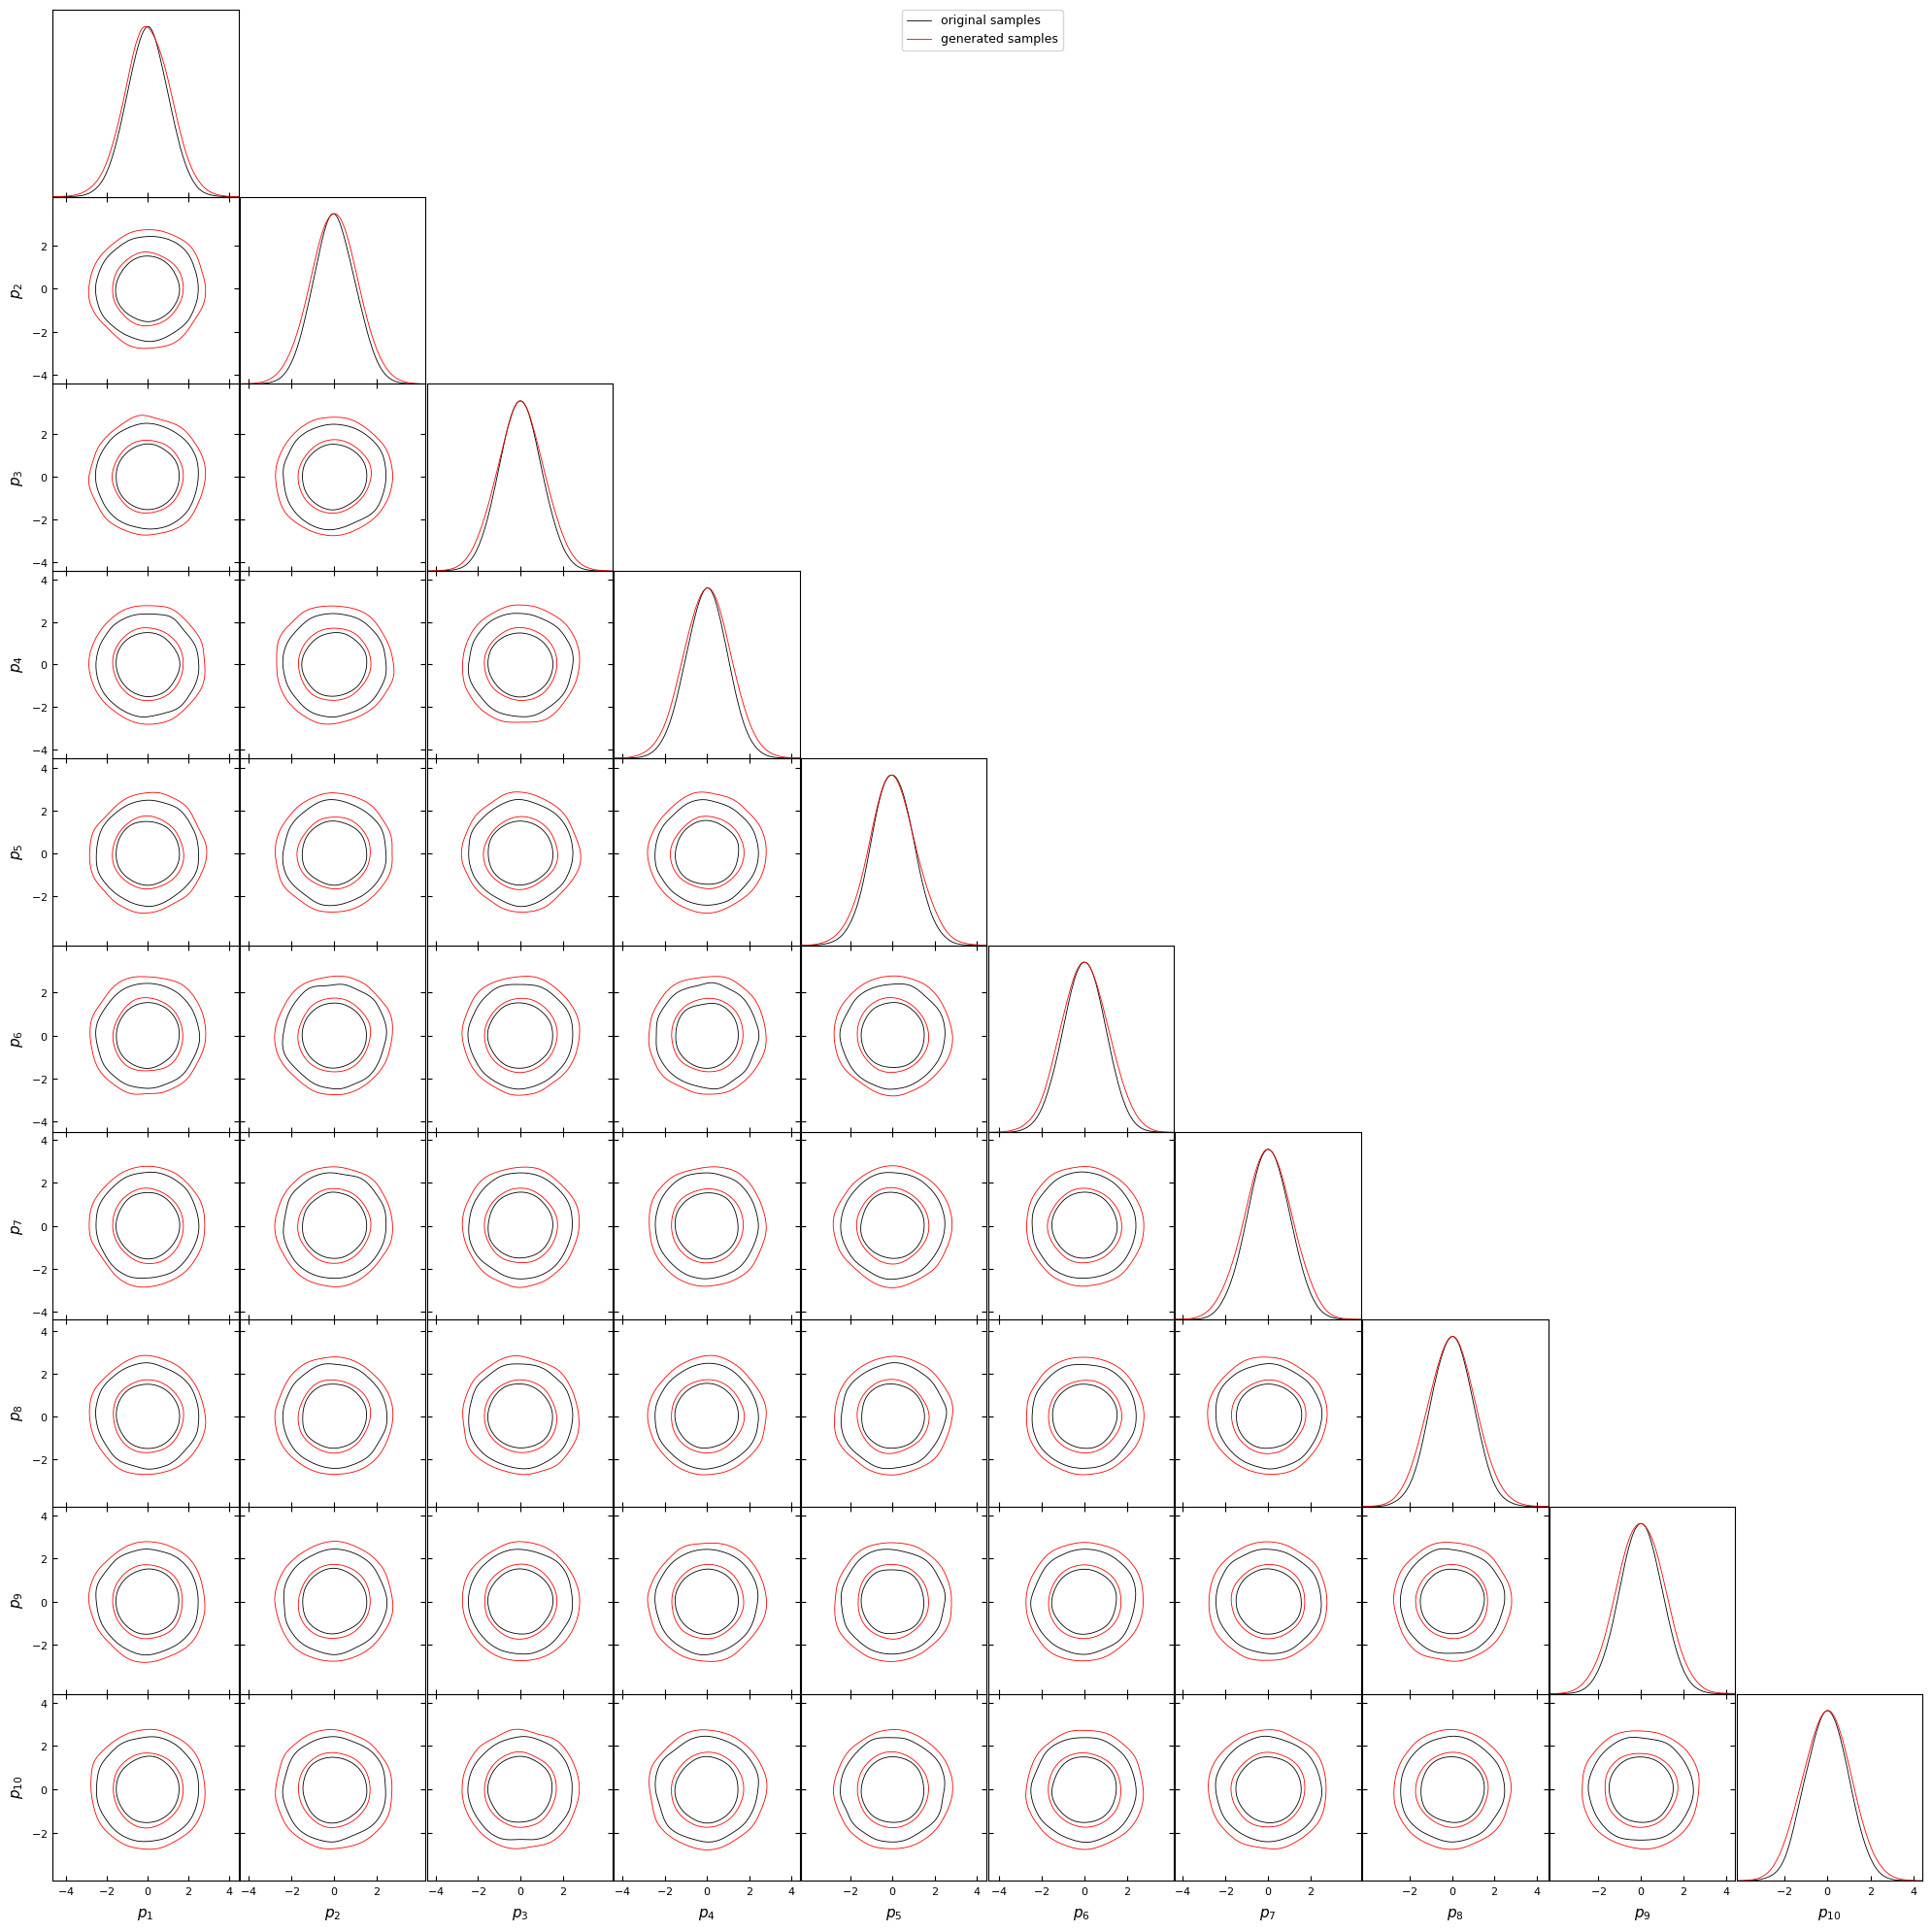

In [16]:
plot_corner(samples, kde) # Plot using KDE

Removed no burn in
Removed no burn in


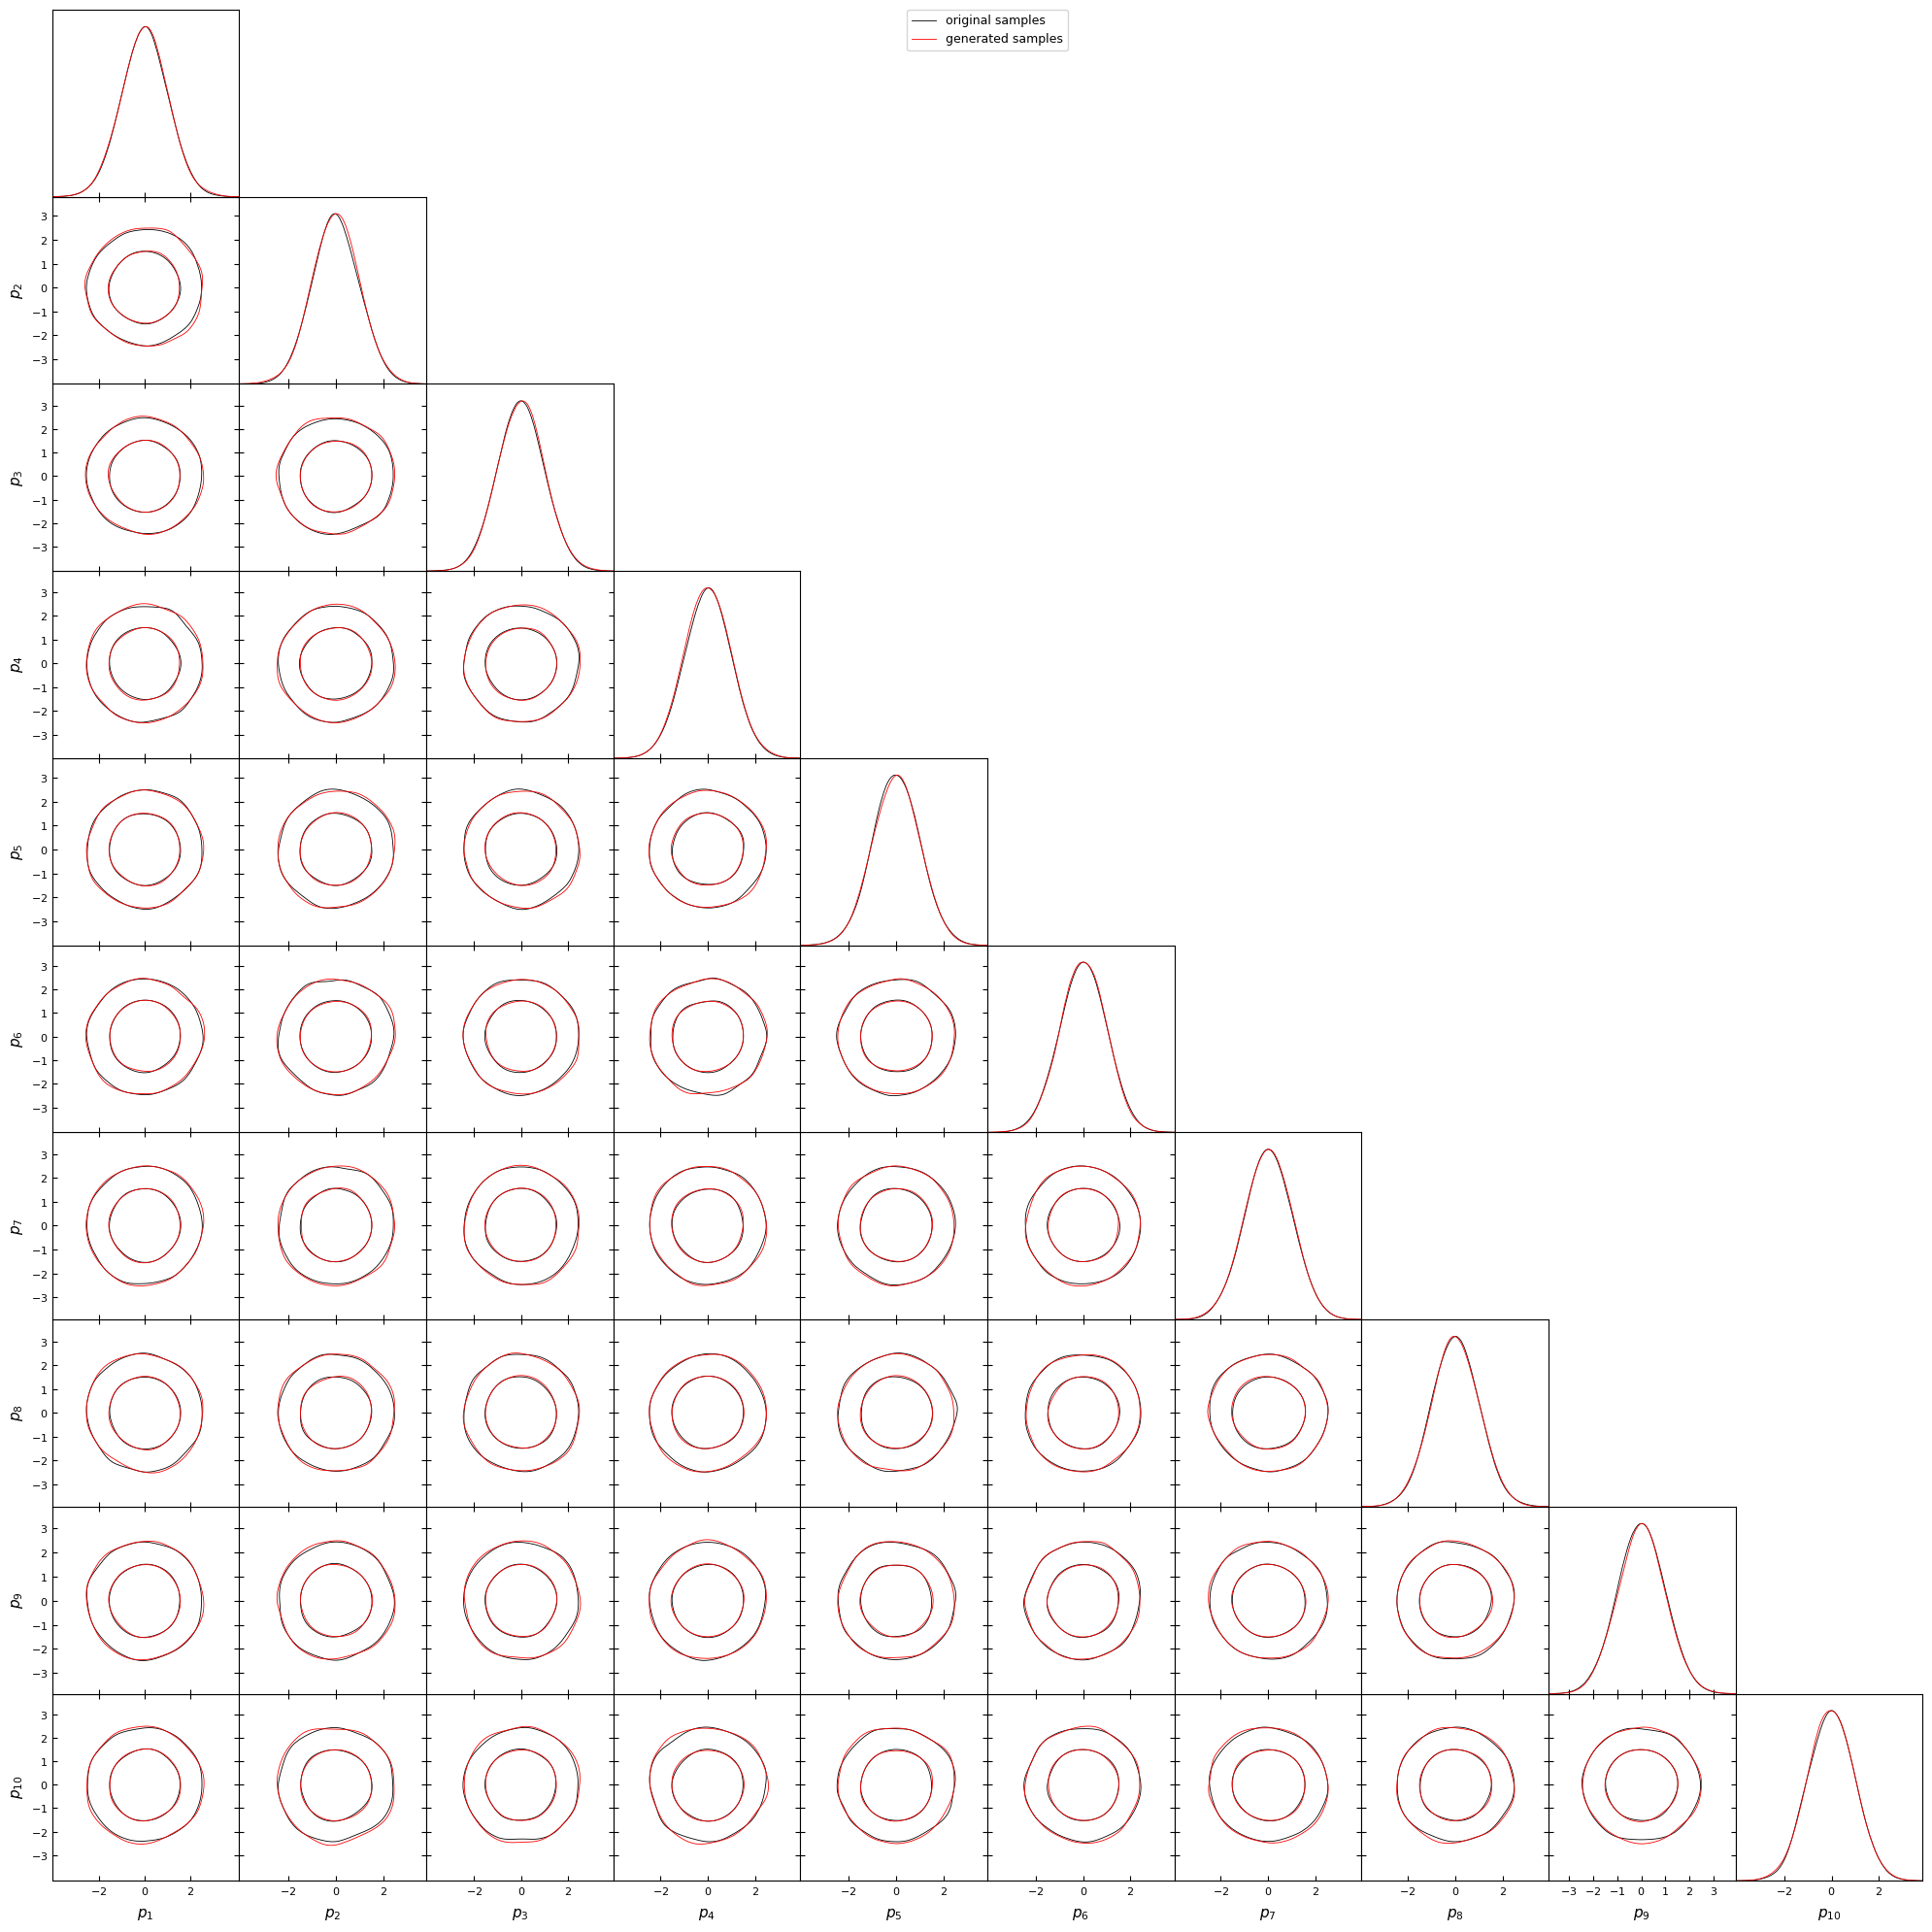

In [17]:
plot_corner(samples, nfde) # Plot using denmarf